# Importing the needed Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from scipy.stats import pearsonr
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import calendar
from matplotlib.ticker import FuncFormatter
import datetime
import joblib
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Loading the Energy and Treated Water Data

In [2]:
others = pd.read_csv('almeda_data.csv')

other = others
others.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2021,1,1,0,30,6.7,0,0,0,0,...,0,98.33,164.94,0.16,1026,1.5,318,1.2,0.0000,0.0000
1,2021,1,1,1,30,7.0,0,0,0,0,...,0,95.58,157.77,0.16,1026,1.5,309,1.1,0.0000,0.0000
2,2021,1,1,10,30,14.4,70,831,422,0,...,422,52.85,64.97,0.16,1027,1.3,197,1.2,22.5139,17.5246
3,2021,1,1,11,30,16.4,76,863,492,3,...,395,38.49,61.20,0.16,1027,1.3,242,1.1,21.6196,16.8738
4,2021,1,1,12,30,17.0,80,854,500,7,...,381,35.19,60.55,0.16,1027,1.4,265,1.1,20.9364,16.3469


In [3]:
energy_data = pd.read_excel('Almeda Electrical Info 1.xlsx')
energy_data.head()

,end of billing period,Electrical,On-Peak Usage (kWh),Part-Peak Usage (kWh),Off-Peak Usage (kWh),Total Usage (kWh),Charges (dollars),Billing Demand (kW),Created Demand (kW),On-Peak Demand (kW),Part-Peak Demand (kW),Off-Peak Demand (kW)
0,2023-06-01,87810.22,NaN,NaN,NaN,393447.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-01,82891.88,NaN,NaN,NaN,428607.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-01,68746.43,NaN,NaN,NaN,362335.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-01,68659.27,NaN,NaN,NaN,352314.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-01,73939.40,NaN,NaN,NaN,372816.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
flow_data = pd.read_excel('Almeda Flows.xlsx')
flow_data.head()

,Date,BPW Flow Average (MGD)
0,2013-06-22,9.81
1,2013-06-23,9.81
2,2013-06-24,9.82
3,2013-06-25,8.81
4,2013-06-26,8.64


# Data Exploration and Preprocessing

In [5]:
column_data_types = others.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                                             int64
Month                                            int64
Day                                              int64
Hour                                             int64
Minute                                           int64
Temperature                                    float64
Clearsky DHI                                     int64
Clearsky DNI                                     int64
Clearsky GHI                                     int64
Cloud Type                                       int64
Dew Point                                      float64
DHI                                              int64
DNI                                              int64
Fill Flag                                        int64
GHI                                              int64
Relative Humidity                              float64
Solar Zenith Angle                             float64
Surface

In [6]:
column_data_types = energy_data.dtypes

# Print the data types
print("Data types of each column in the in Energy Consumption DataFrame:")
print(column_data_types)

Data types of each column in the in Energy Consumption DataFrame:
end of billing period    datetime64[ns]
Electrical                      float64
On-Peak Usage (kWh)             float64
Part-Peak Usage (kWh)           float64
Off-Peak Usage (kWh)            float64
Total Usage (kWh)               float64
Charges (dollars)               float64
Billing Demand (kW)             float64
Created Demand (kW)             float64
On-Peak Demand (kW)             float64
Part-Peak Demand (kW)           float64
Off-Peak Demand (kW)            float64
dtype: object


In [7]:
rows, columns = flow_data.shape
print(f"flow_data has {rows} rows and {columns} columns.")

flow_data has 3650 rows and 2 columns.


In [8]:
column_data_types = flow_data.dtypes

# Print the data types
print("Data types of each column in the in Water Flow DataFrame:")
print(column_data_types)

Data types of each column in the in Water Flow DataFrame:
Date                      datetime64[ns]
BPW Flow Average (MGD)           float64
dtype: object


In [9]:
# Convert Month, Day, and Year columns to a datetime format
others['Date'] = pd.to_datetime(others['Year'].astype(str) + '-' + others['Month'].astype(str) + '-' + others['Day'].astype(str), errors='coerce')

other['Date'] = pd.to_datetime(other['Year'].astype(str) + '-' + other['Month'].astype(str) + '-' + other['Day'].astype(str), errors='coerce')



In [10]:
others = pd.get_dummies(others, columns=['Month'], drop_first=True)

# Convert 'Day of the Month' to integer if it's an object
if others['Day'].dtype == 'object':
    others['Day'] = others['Day'].astype(int)


In [11]:
column_data_types = others.dtypes

# Print the data types
print("Data types of each column in the in predictors DataFrame:")
print(column_data_types)

Data types of each column in the in predictors DataFrame:
Year                                                    int64
Day                                                     int64
Hour                                                    int64
Minute                                                  int64
Temperature                                           float64
Clearsky DHI                                            int64
Clearsky DNI                                            int64
Clearsky GHI                                            int64
Cloud Type                                              int64
Dew Point                                             float64
DHI                                                     int64
DNI                                                     int64
Fill Flag                                               int64
GHI                                                     int64
Relative Humidity                                     float64
Solar Zenith

In [12]:
# Check for duplicate dates in flow_data and others
flow_duplicates = flow_data[flow_data['Date'].duplicated()]
others_duplicates = others[others['Date'].duplicated()]

print(f"Number of duplicate dates in flow_data: {len(flow_duplicates)}")
print(f"Number of duplicate dates in others: {len(others_duplicates)}")

# Drop duplicate dates in both dataframes (keep the first occurrence)
flow_data = flow_data.drop_duplicates(subset='Date', keep='first')
others = others.drop_duplicates(subset='Date', keep='first')

# Merge the dataframes on the 'Date' column again
flow_data = pd.merge(flow_data, others, on='Date', how='inner')

print(f"Number of rows in the merged dataframe: {len(flow_data)}")


Number of duplicate dates in flow_data: 0
Number of duplicate dates in others: 100740
Number of rows in the merged dataframe: 3111


In [13]:
rows, columns = flow_data.shape
print(f"flow_data has {rows} rows and {columns} columns.")

flow_data has 3111 rows and 36 columns.


In [14]:
# Display the first few rows of the modified dataframe
print(flow_data.head())


        Date  BPW Flow Average (MGD)  Year  Day  Hour  Minute  Temperature  \
0 2013-06-22                    9.81  2013   22     0      30         12.5   
1 2013-06-23                    9.81  2013   23     0      30         15.1   
2 2013-06-24                    9.82  2013   24     0      30         16.3   
3 2013-06-25                    8.81  2013   25     0      30         16.4   
4 2013-06-26                    8.64  2013   26     0      30         17.7   

   Clearsky DHI  Clearsky DNI  Clearsky GHI  ...  Month_3  Month_4  Month_5  \
0             0             0             0  ...    False    False    False   
1             0             0             0  ...    False    False    False   
2             0             0             0  ...    False    False    False   
3             0             0             0  ...    False    False    False   
4             0             0             0  ...    False    False    False   

   Month_6  Month_7  Month_8  Month_9  Month_10  Month_1

In [15]:
# Check for missing values in each column of flow_data
missing_values = flow_data.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

Missing values in each column before removal:
Date                                           0
BPW Flow Average (MGD)                         0
Year                                           0
Day                                            0
Hour                                           0
Minute                                         0
Temperature                                    0
Clearsky DHI                                   0
Clearsky DNI                                   0
Clearsky GHI                                   0
Cloud Type                                     0
Dew Point                                      0
DHI                                            0
DNI                                            0
Fill Flag                                      0
GHI                                            0
Relative Humidity                              0
Solar Zenith Angle                             0
Surface Albedo                                 0
Pressure               

In [16]:
column_data_types = flow_data.dtypes

# Print the data types
print("Data types of each column in the in Water Flow DataFrame:")
print(column_data_types)

Data types of each column in the in Water Flow DataFrame:
Date                                           datetime64[ns]
BPW Flow Average (MGD)                                float64
Year                                                    int64
Day                                                     int64
Hour                                                    int64
Minute                                                  int64
Temperature                                           float64
Clearsky DHI                                            int64
Clearsky DNI                                            int64
Clearsky GHI                                            int64
Cloud Type                                              int64
Dew Point                                             float64
DHI                                                     int64
DNI                                                     int64
Fill Flag                                               int64
GHI         

In [17]:
# Extract 'Total Usage (kWh)' and 'end of billing period' columns
energy_data = energy_data[['Total Usage (kWh)', 'end of billing period']]

# Rename 'end of billing period' to 'Date'
energy_data = energy_data.rename(columns={'end of billing period': 'Date'})

# Display the first few rows of the modified DataFrame
print(energy_data.head())


   Total Usage (kWh)       Date
0           393447.0 2023-06-01
1           428607.0 2023-05-01
2           362335.0 2023-04-01
3           352314.0 2023-03-01
4           372816.0 2023-02-01


In [18]:
# Merge the dataframes on the 'Date' column
energy_data = pd.merge(energy_data, other, on='Date', how='inner')

# Display the first few rows of the merged dataframe
print(energy_data.head())

   Total Usage (kWh)       Date  Year  Month  Day  Hour  Minute  Temperature  \
0            51235.0 2021-12-01  2021     12    1     0      30         11.0   
1            51235.0 2021-12-01  2021     12    1     1      30         10.6   
2            51235.0 2021-12-01  2021     12    1    10      30         20.3   
3            51235.0 2021-12-01  2021     12    1    11      30         22.7   
4            51235.0 2021-12-01  2021     12    1    12      30         24.2   

   Clearsky DHI  Clearsky DNI  ...  GHI  Relative Humidity  \
0             0             0  ...    0              97.70   
1             0             0  ...    0             100.00   
2            71           863  ...  465              60.48   
3            74           890  ...  522              51.60   
4            73           892  ...  520              47.36   

   Solar Zenith Angle  Surface Albedo  Pressure  Precipitable Water  \
0              162.81            0.15      1026                 1.4   
1   

In [19]:
# Display the first few rows of the modified dataframe
print(energy_data.head())


   Total Usage (kWh)       Date  Year  Month  Day  Hour  Minute  Temperature  \
0            51235.0 2021-12-01  2021     12    1     0      30         11.0   
1            51235.0 2021-12-01  2021     12    1     1      30         10.6   
2            51235.0 2021-12-01  2021     12    1    10      30         20.3   
3            51235.0 2021-12-01  2021     12    1    11      30         22.7   
4            51235.0 2021-12-01  2021     12    1    12      30         24.2   

   Clearsky DHI  Clearsky DNI  ...  GHI  Relative Humidity  \
0             0             0  ...    0              97.70   
1             0             0  ...    0             100.00   
2            71           863  ...  465              60.48   
3            74           890  ...  522              51.60   
4            73           892  ...  520              47.36   

   Solar Zenith Angle  Surface Albedo  Pressure  Precipitable Water  \
0              162.81            0.15      1026                 1.4   
1   

In [20]:
# Check for missing values in each column of flow_data
missing_values = energy_data.isna().sum()
print("Missing values in each column before removal:")
print(missing_values)

# Check if there are any missing values in the DataFrame
if missing_values.any():
    # Drop rows with missing values
    energy_data.dropna(inplace=True)
    print("Rows with missing values have been removed.")

# Verify that there are no more missing values
missing_values_after = energy_data.isna().sum()
print("Missing values in each column after removal:")
print(missing_values_after)


Missing values in each column before removal:
Total Usage (kWh)                              336
Date                                             0
Year                                             0
Month                                            0
Day                                              0
Hour                                             0
Minute                                           0
Temperature                                      0
Clearsky DHI                                     0
Clearsky DNI                                     0
Clearsky GHI                                     0
Cloud Type                                       0
Dew Point                                        0
DHI                                              0
DNI                                              0
Fill Flag                                        0
GHI                                              0
Relative Humidity                                0
Solar Zenith Angle                  

In [21]:
print(energy_data.head())

   Total Usage (kWh)       Date  Year  Month  Day  Hour  Minute  Temperature  \
0            51235.0 2021-12-01  2021     12    1     0      30         11.0   
1            51235.0 2021-12-01  2021     12    1     1      30         10.6   
2            51235.0 2021-12-01  2021     12    1    10      30         20.3   
3            51235.0 2021-12-01  2021     12    1    11      30         22.7   
4            51235.0 2021-12-01  2021     12    1    12      30         24.2   

   Clearsky DHI  Clearsky DNI  ...  GHI  Relative Humidity  \
0             0             0  ...    0              97.70   
1             0             0  ...    0             100.00   
2            71           863  ...  465              60.48   
3            74           890  ...  522              51.60   
4            73           892  ...  520              47.36   

   Solar Zenith Angle  Surface Albedo  Pressure  Precipitable Water  \
0              162.81            0.15      1026                 1.4   
1   

In [22]:
# Get the length of flow_data and energy_data
len_flow_data = len(flow_data)
len_energy_data = len(energy_data)

# Print the lengths
print(f"Length of flow_data: {len_flow_data}")
print(f"Length of energy_data: {len_energy_data}")


Length of flow_data: 3111
Length of energy_data: 1248


# Time series data Decomposition and Time Plot

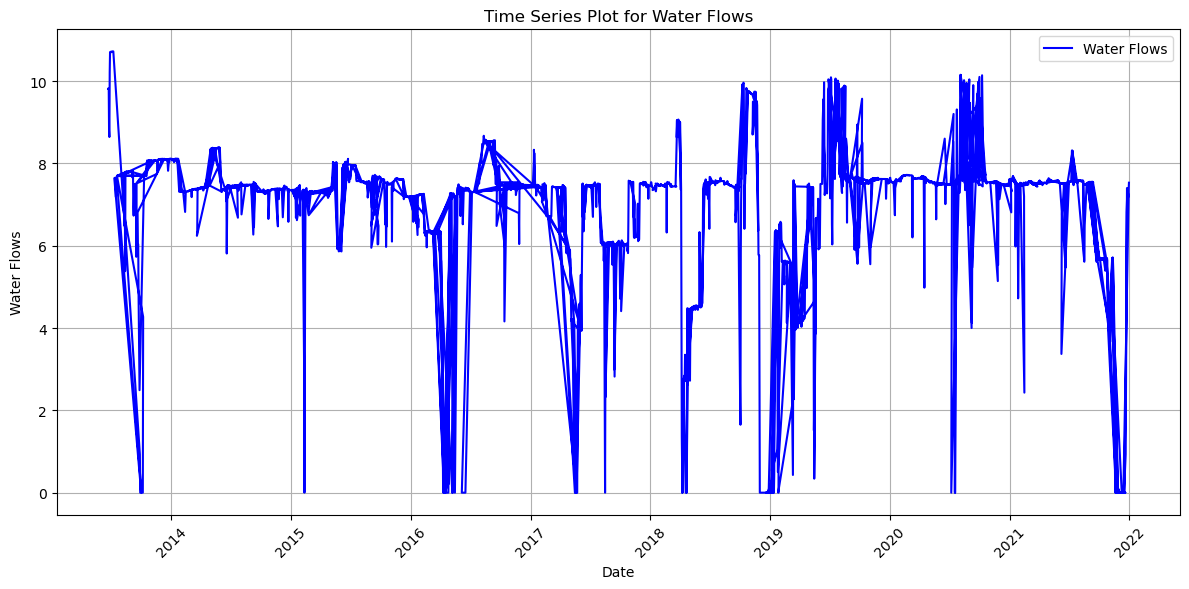

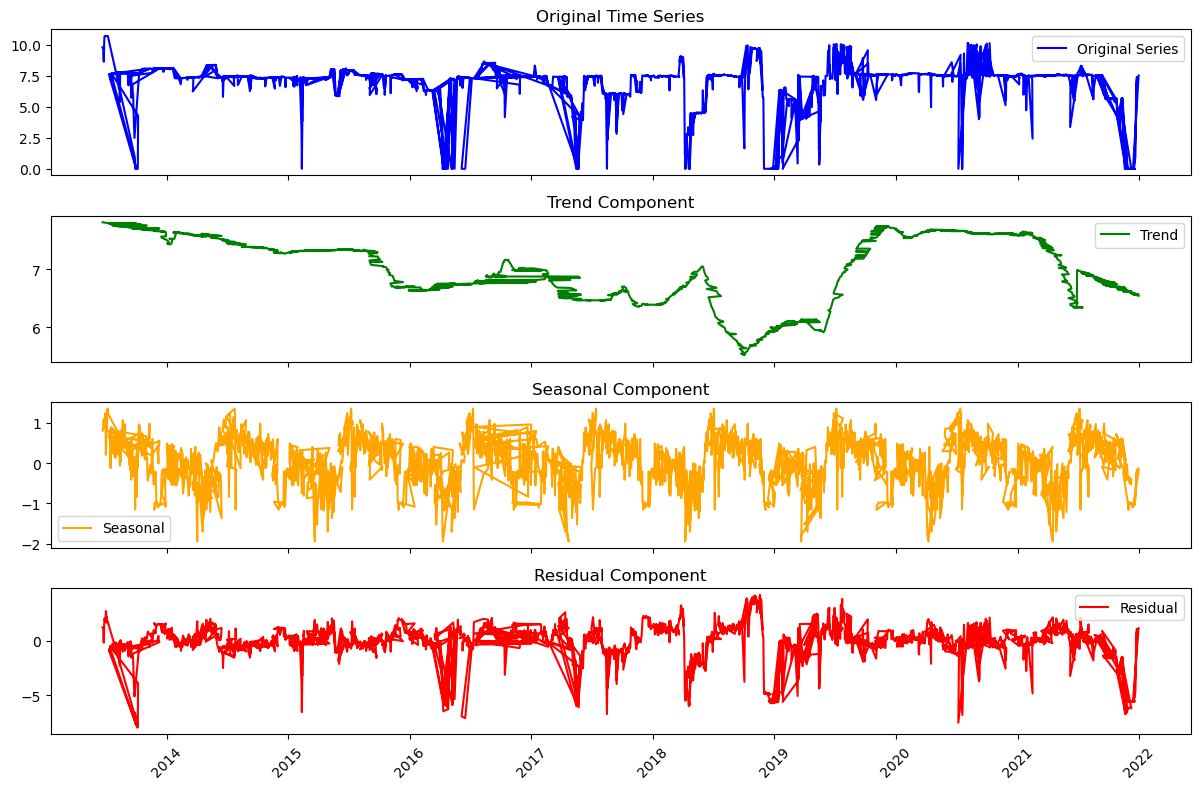

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'BPW Flow Average (MGD)' series
decomposition_treated = seasonal_decompose(flow_data['BPW Flow Average (MGD)'], period=365, extrapolate_trend='freq')

# Time series plot for 'Water Flows'
plt.figure(figsize=(12, 6))
plt.plot(flow_data['Date'], flow_data['BPW Flow Average (MGD)'], label='Water Flows', color='blue')
plt.title('Time Series Plot for Water Flows')
plt.xlabel('Date')
plt.ylabel('Water Flows')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()  # Extract the components
trend = decomposition_treated.trend
seasonal = decomposition_treated.seasonal
residual = decomposition_treated.resid

# Create subplots for each component along with the original time series
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

# Original Time Series
axes[0].plot(flow_data['Date'], flow_data['BPW Flow Average (MGD)'], label='Original Series', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Trend
axes[1].plot(flow_data['Date'], trend, label='Trend', color='green')
axes[1].set_title('Trend Component')
axes[1].legend()

# Seasonal
axes[2].plot(flow_data['Date'], seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal Component')
axes[2].legend()

# Residual
axes[3].plot(flow_data['Date'], residual, label='Residual', color='red')
axes[3].set_title('Residual Component')
axes[3].legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()


plt.show()


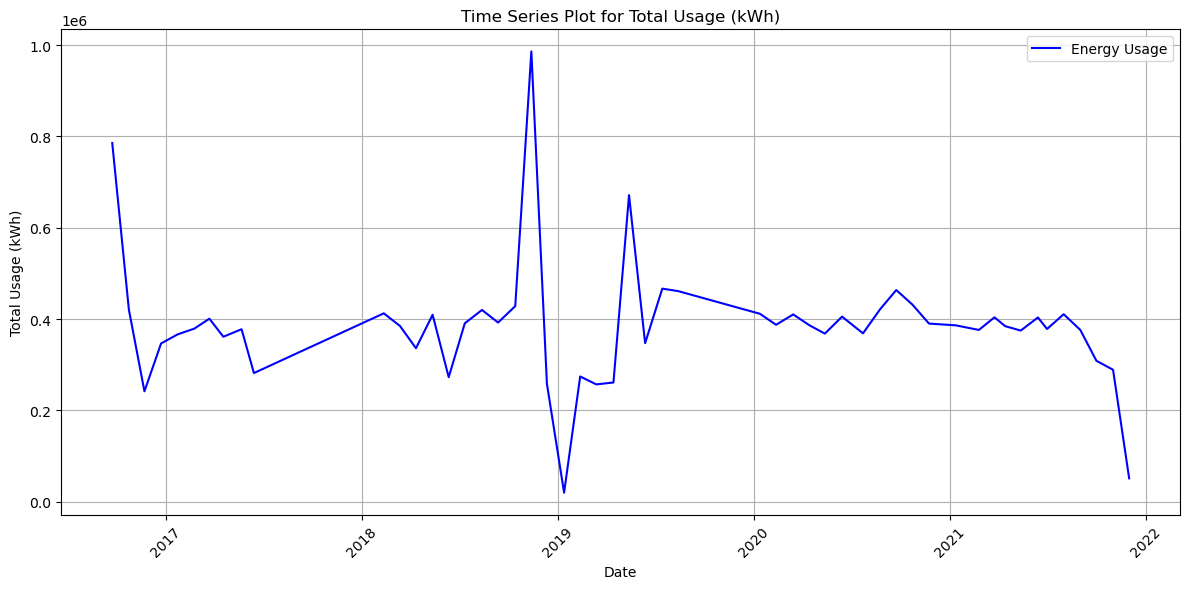

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(energy_data['Date'], energy_data['Total Usage (kWh)'], label='Energy Usage', color='blue')
plt.title('Time Series Plot for Total Usage (kWh)')
plt.xlabel('Date')
plt.ylabel('Total Usage (kWh)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Lag Creation

In [25]:
# Number of lags to create
n_lags = 3

# Create lagged features for "Water Flows"
for i in range(1, n_lags + 1):
    col_name = f'Water_Flows_Lag_{i}'
    flow_data[col_name] = flow_data['BPW Flow Average (MGD)'].shift(i)

# Remove the rows with NaN values generated by shifting
flow_data.dropna(inplace=True)

# Show the first few rows to confirm
print(flow_data.head())

        Date  BPW Flow Average (MGD)  Year  Day  Hour  Minute  Temperature  \
3 2013-06-25                    8.81  2013   25     0      30         16.4   
4 2013-06-26                    8.64  2013   26     0      30         17.7   
5 2013-06-27                   10.21  2013   27     0      30         16.7   
6 2013-06-28                   10.70  2013   28     0      30         18.1   
7 2013-06-29                   10.71  2013   29     0      30         19.2   

   Clearsky DHI  Clearsky DNI  Clearsky GHI  ...  Month_6  Month_7  Month_8  \
3             0             0             0  ...     True    False    False   
4             0             0             0  ...     True    False    False   
5             0             0             0  ...     True    False    False   
6             0             0             0  ...     True    False    False   
7             0             0             0  ...     True    False    False   

   Month_9  Month_10  Month_11  Month_12  Water_Flows_La

In [26]:
# Number of lags to create
n_lags = 3

# Create lagged features for "Water Flows"
for i in range(1, n_lags + 1):
    col_name = f'Energy_Lag_{i}'
    energy_data[col_name] = energy_data['Total Usage (kWh)'].shift(i)

# Remove the rows with NaN values generated by shifting
energy_data.dropna(inplace=True)

# Show the first few rows to confirm
print(energy_data.head())

   Total Usage (kWh)       Date  Year  Month  Day  Hour  Minute  Temperature  \
3            51235.0 2021-12-01  2021     12    1    11      30         22.7   
4            51235.0 2021-12-01  2021     12    1    12      30         24.2   
5            51235.0 2021-12-01  2021     12    1    13      30         24.9   
6            51235.0 2021-12-01  2021     12    1    14      30         24.7   
7            51235.0 2021-12-01  2021     12    1    15      30         24.4   

   Clearsky DHI  Clearsky DNI  ...  Surface Albedo  Pressure  \
3            74           890  ...            0.15      1026   
4            73           892  ...            0.15      1025   
5            68           867  ...            0.15      1025   
6            59           801  ...            0.15      1024   
7            46           655  ...            0.15      1024   

   Precipitable Water  Wind Direction  Wind Speed  \
3                 1.1              93         1.8   
4                 1.1       

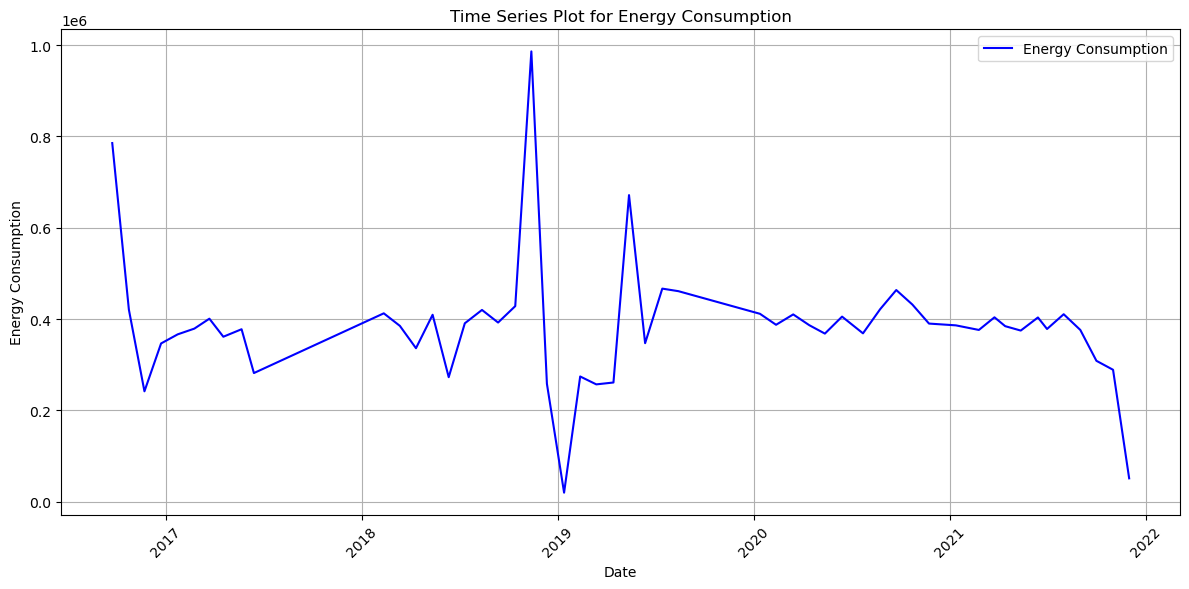

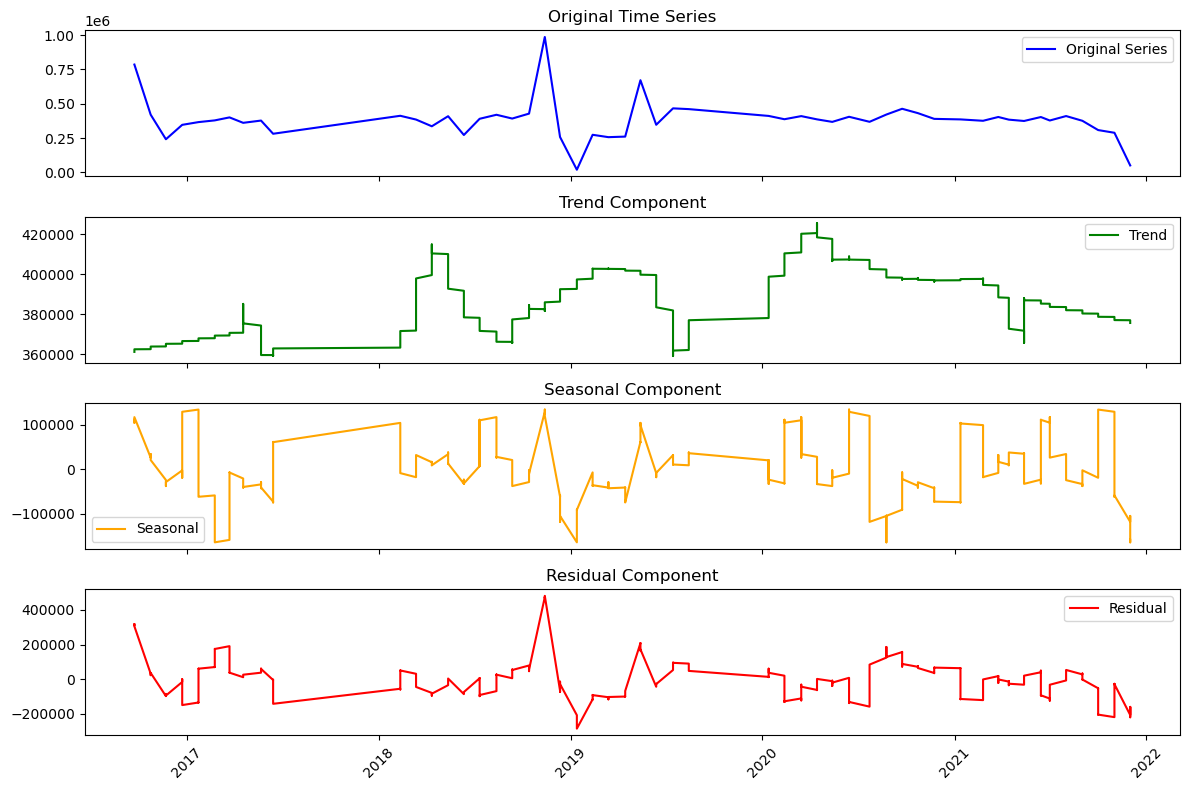

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'Energy Consumption Data' series
decomposition_treated = seasonal_decompose(energy_data['Total Usage (kWh)'], period=365, extrapolate_trend='freq')

# Time series plot for 'Energy Consumption'
plt.figure(figsize=(12, 6))
plt.plot(energy_data['Date'], energy_data['Total Usage (kWh)'], label='Energy Consumption', color='blue')
plt.title('Time Series Plot for Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()  # Extract the components
trend = decomposition_treated.trend
seasonal = decomposition_treated.seasonal
residual = decomposition_treated.resid

# Create subplots for each component along with the original time series
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

# Original Time Series
axes[0].plot(energy_data['Date'], energy_data['Total Usage (kWh)'], label='Original Series', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Trend
axes[1].plot(energy_data['Date'], trend, label='Trend', color='green')
axes[1].set_title('Trend Component')
axes[1].legend()

# Seasonal
axes[2].plot(energy_data['Date'], seasonal, label='Seasonal', color='orange')
axes[2].set_title('Seasonal Component')
axes[2].legend()

# Residual
axes[3].plot(energy_data['Date'], residual, label='Residual', color='red')
axes[3].set_title('Residual Component')
axes[3].legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Unit Root Test to explore Stationarity

In [28]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ')

# Apply the test on your time series data
adf_test(flow_data['BPW Flow Average (MGD)'])
adf_test(energy_data['Total Usage (kWh)'])

ADF Statistic: -6.026108222272972
p-value: 1.4546682139672776e-07
Critical Values: {'1%': -3.4324728521095658, '5%': -2.8624779427668594, '10%': -2.5672692900180105}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
ADF Statistic: -4.4512625140959345
p-value: 0.00024060128513686693
Critical Values: {'1%': -3.4356175602072545, '5%': -2.8638661490437025, '10%': -2.5680084710921105}
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# 50:50 Data Partitioning for Treated Water

In [29]:
# Split sizes for Treated Water
train_size = int(len(flow_data) * 0.5)  # 50% for training

# Train-Test Split
train, test = flow_data[:train_size], flow_data[train_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'BPW Flow Average (MGD)'], axis=1)
y_train_treated_actual = train['BPW Flow Average (MGD)']

# Test data
X_test_actual = test.drop(['Date', 'BPW Flow Average (MGD)'], axis=1)
y_test_treated_actual = test['BPW Flow Average (MGD)']

print("Training set size:", len(X_train_actual))
print("Test set size:", len(X_test_actual))

Training set size: 1554
Test set size: 1554


# 50: 50 Data Partitioning for Energy Consumption

In [30]:
# Split sizes for Energy Consumption
train_size_energy = int(len(energy_data) * 0.5)  # 50% for training

# Train-Test Split
train_energy, test_energy = energy_data[:train_size_energy], energy_data[train_size_energy:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual_energy = train_energy.drop(['Date', 'Total Usage (kWh)'], axis=1)
y_train_actual_energy = train_energy['Total Usage (kWh)']

# Test data
X_test_actual_energy = test_energy.drop(['Date', 'Total Usage (kWh)'], axis=1)
y_test_actual_energy = test_energy['Total Usage (kWh)']

print("Training set size:", len(X_train_actual_energy))
print("Test set size:", len(X_test_actual_energy))


Training set size: 622
Test set size: 623


# Initial ML Model and SARIMA for Treated Water

In [31]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

In [32]:
# Machine Learning Model Training for Treated Water
rf_model_treated = RandomForestRegressor()
rf_model_treated.fit(X_train_actual, y_train_treated_actual)

gb_model_treated = GradientBoostingRegressor()
gb_model_treated.fit(X_train_actual, y_train_treated_actual)

# SARIMA Model Training for Treated Water
try:
    sarima_model_treated = SARIMAX(y_train_treated_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_treated = sarima_model_treated.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Treated Water:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Initial ML Model and SARIMA for Energy Consumption

In [33]:
# Machine Learning Model Training for Energy Consumption
rf_model_energy = RandomForestRegressor()
rf_model_energy.fit(X_train_actual_energy, y_train_actual_energy)

gb_model_energy = GradientBoostingRegressor()
gb_model_energy.fit(X_train_actual_energy, y_train_actual_energy)


# SARIMA Model Training for Energy Consumption
try:
    sarima_model_energy = SARIMAX(y_train_actual_energy, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_energy = sarima_model_energy.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Energy Consumption:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# Prediction from Initial ML and SARIMA Model for Treated Water on Test Dataset on 50:50 dataset

In [34]:
# Predictions using Random Forest
rf_pred_flow = rf_model_treated.predict(X_test_actual)

# Predictions using Gradient Boosting
gb_pred_flow = gb_model_treated.predict(X_test_actual)

# Predictions using SARIMA
start_point_flow = len(y_train_treated_actual)
end_point_flow = start_point_flow + len(X_test_actual) - 1
sarima_pred_flow = sarima_fit_treated.predict(start=start_point_flow, end=end_point_flow)

# Ensemble Predictions for Treated Water
flow_outputs = [rf_pred_flow, gb_pred_flow, sarima_pred_flow]
ensemble_pred_flow = np.mean(flow_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Prediction from Initial ML and SARIMA Model for Energy Consumption on Test

In [35]:
# Predictions using Random Forest
rf_pred_energy = rf_model_energy.predict(X_test_actual_energy)

# Predictions using Gradient Boosting
gb_pred_energy = gb_model_energy.predict(X_test_actual_energy)

# Predictions using SARIMA Model
start_point_energy = len(y_train_actual_energy)
end_point_energy = start_point_energy + len(X_test_actual_energy) - 1
sarima_pred_energy = sarima_fit_energy.predict(start=start_point_energy, end=end_point_energy)

# Ensemble Predictions for Energy Consumption
energy_outputs = [rf_pred_energy, gb_pred_energy, sarima_pred_energy]
ensemble_pred_energy = np.mean(energy_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Model Assessment for Initial Models

In [36]:
def error(y_true, y_pred, threshold=0.5):
    """
    Calculate the error rate based on a given threshold.
    The function returns the proportion of predictions that are off by more than the threshold.
    """
    return np.mean(np.abs(y_true - y_pred) > threshold)

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)
    
    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_flow, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_flow, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_flow, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_flow, "Ensemble")
    
    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_actual_energy, rf_pred_energy, "Random Forest")
    evaluate_predictions(y_test_actual_energy, gb_pred_energy, "Gradient Boosting")
    evaluate_predictions(y_test_actual_energy, sarima_pred_energy, "SARIMA")
    evaluate_predictions(y_test_actual_energy, ensemble_pred_energy, "Ensemble")

# Run the evaluations
main()

Evaluations for Water Flow:

=== Random Forest ===
RMSE: 1.4510
MAE: 0.8326
Error Rate: 0.4028

=== Gradient Boosting ===
RMSE: 1.7944
MAE: 1.1754
Error Rate: 0.6203

=== SARIMA ===
RMSE: 2.8475
MAE: 2.5799
Error Rate: 0.9345

=== Ensemble ===
RMSE: 1.8124
MAE: 1.4188
Error Rate: 0.8655

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 158873.4861
MAE: 86561.2697
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 169396.0328
MAE: 99510.9886
Error Rate: 1.0000

=== SARIMA ===
RMSE: 746244.8676
MAE: 697727.1172
Error Rate: 0.4438

=== Ensemble ===
RMSE: 276773.5346
MAE: 257634.7533
Error Rate: 1.0000



# 60:20:20 Data Partitioning on Training, Testing and validation Data for Treated Water

In [38]:
# Split sizes for Treated Water
train_size = int(len(flow_data) * 0.6)  # 60% for training
validation_size = int(len(flow_data) * 0.2)  # 20% for validation

# Train-Validation-Test Split
train, temp = flow_data[:train_size], flow_data[train_size:]
validation, test = temp[:validation_size], temp[validation_size:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual = train.drop(['Date', 'BPW Flow Average (MGD)'], axis=1)
y_train_treated_actual = train['BPW Flow Average (MGD)']

# Validation data
X_validation_actual = validation.drop(['Date', 'BPW Flow Average (MGD)'], axis=1)
y_validation_treated_actual = validation['BPW Flow Average (MGD)']


# Test data
X_test_actual = test.drop(['Date', 'BPW Flow Average (MGD)'],  axis=1)
y_test_treated_actual = test['BPW Flow Average (MGD)']


print("Training set size:", len(X_train_actual))
print("Validation set size:", len(X_validation_actual))
print("Test set size:", len(X_test_actual))

Training set size: 1864
Validation set size: 621
Test set size: 623


# 60:20:20 Data Partitioning on Training, Testing and validation Data for Energy Consumption

In [39]:
# Split sizes for Energy Consumption
train_size_energy = int(len(energy_data) * 0.6)  # 60% for training
validation_size_energy = int(len(energy_data) * 0.2)  # 20% for validation

# Train-Validation-Test Split
train_energy, temp_energy = energy_data[:train_size_energy], energy_data[train_size_energy:]
validation_energy, test_energy = temp_energy[:validation_size_energy], temp_energy[validation_size_energy:]

# Prepare data for machine learning models for actual values

# Training data
X_train_actual_energy = train_energy.drop(['Date', 'Total Usage (kWh)'], axis=1)
y_train_actual_energy = train_energy['Total Usage (kWh)']

# Validation data
X_validation_actual_energy = validation_energy.drop(['Date', 'Total Usage (kWh)'], axis=1)
y_validation_actual_energy = validation_energy['Total Usage (kWh)']


# Test data
X_test_actual_energy = test_energy.drop(['Date', 'Total Usage (kWh)'],  axis=1)
y_test_actual_energy = test_energy['Total Usage (kWh)']


print("Training set size:", len(X_train_actual_energy))
print("Validation set size:", len(X_validation_actual_energy))
print("Test set size:", len(X_test_actual_energy))

Training set size: 747
Validation set size: 249
Test set size: 249


# ML Model and SARIMA on  60% Training Data for Treated Water

In [40]:
# Machine Learning Model Training for Treated Water
rf_model_treated = RandomForestRegressor()
rf_model_treated.fit(X_train_actual, y_train_treated_actual)

gb_model_treated = GradientBoostingRegressor()
gb_model_treated.fit(X_train_actual, y_train_treated_actual)

# SARIMA Model Training for Treated Water
try:
    sarima_model_treated = SARIMAX(y_train_treated_actual, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_treated = sarima_model_treated.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Treated Water:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# ML Model and SARIMA on  60% Training Data for Energy Consumption

In [41]:
# Machine Learning Model Training for Energy Consumption
rf_model_energy = RandomForestRegressor()
rf_model_energy.fit(X_train_actual_energy, y_train_actual_energy)

gb_model_energy = GradientBoostingRegressor()
gb_model_energy.fit(X_train_actual_energy, y_train_actual_energy)


# SARIMA Model Training for Energy Consumption
try:
    sarima_model_energy = SARIMAX(y_train_actual_energy, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fit_energy = sarima_model_energy.fit(disp=False)
except Exception as e:
    print("Error fitting SARIMA model for Energy Consumption:", str(e))

C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Model Prediction on Test Dataset for Treated Water

In [42]:
# Predictions using Random Forest
rf_pred_flow = rf_model_treated.predict(X_test_actual)

# Predictions using Gradient Boosting
gb_pred_flow = gb_model_treated.predict(X_test_actual)

# Predictions using SARIMA
start_point_flow = len(y_train_treated_actual)
end_point_flow = start_point_flow + len(X_test_actual) - 1
sarima_pred_flow = sarima_fit_treated.predict(start=start_point_flow, end=end_point_flow)

# Ensemble Predictions for Treated Water
flow_outputs = [rf_pred_flow, gb_pred_flow, sarima_pred_flow]
ensemble_pred_flow = np.mean(flow_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Model Prediction on Test Dataset for Energy Consumption

In [43]:
# Predictions using Random Forest
rf_pred_energy = rf_model_energy.predict(X_test_actual_energy)

# Predictions using Gradient Boosting
gb_pred_energy = gb_model_energy.predict(X_test_actual_energy)

# Predictions using SARIMA Model
start_point_energy = len(y_train_actual_energy)
end_point_energy = start_point_energy + len(X_test_actual_energy) - 1
sarima_pred_energy = sarima_fit_energy.predict(start=start_point_energy, end=end_point_energy)

# Ensemble Predictions for Energy Consumption
energy_outputs = [rf_pred_energy, gb_pred_energy, sarima_pred_energy]
ensemble_pred_energy = np.mean(energy_outputs, axis=0)


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROBERTECH\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Model Assessment for 60% Training Data

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)
    
    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_flow, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_flow, "Gradient Boosting")
    evaluate_predictions(y_test_treated_actual, sarima_pred_flow, "SARIMA")
    evaluate_predictions(y_test_treated_actual, ensemble_pred_flow, "Ensemble")
    
    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_actual_energy, rf_pred_energy, "Random Forest")
    evaluate_predictions(y_test_actual_energy, gb_pred_energy, "Gradient Boosting")
    evaluate_predictions(y_test_actual_energy, sarima_pred_energy, "SARIMA")
    evaluate_predictions(y_test_actual_energy, ensemble_pred_energy, "Ensemble")

# Run the evaluations
main()


Evaluations for Water Flow:

=== Random Forest ===
RMSE: 1.5938
MAE: 0.9107
Error Rate: 0.4013

=== Gradient Boosting ===
RMSE: 1.4823
MAE: 0.7498
Error Rate: 0.2921

=== SARIMA ===
RMSE: 2.0595
MAE: 0.9756
Error Rate: 0.0000

=== Ensemble ===
RMSE: 1.6322
MAE: 0.8450
Error Rate: 0.4029

Evaluations for Energy Consumption:

=== Random Forest ===
RMSE: 62057.7318
MAE: 28700.6282
Error Rate: 1.0000

=== Gradient Boosting ===
RMSE: 92448.0984
MAE: 44826.8162
Error Rate: 1.0000

=== SARIMA ===
RMSE: 203722.3677
MAE: 148222.6582
Error Rate: 0.0000

=== Ensemble ===
RMSE: 110625.5478
MAE: 64631.5246
Error Rate: 1.0000



# Hyper Parameter Tunning on the Gradient Boost Model for Energy Consumption

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid
param_grid_energy = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None, 'sqrt', 'log2', 'auto'],
    'subsample': [0.5, 0.75, 1.0]
}

# Initialize Gradient Boosting Regressor
gb_energy = GradientBoostingRegressor()

# Create the grid search object
grid_search_energy = GridSearchCV(estimator=gb_energy, param_grid=param_grid_energy, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy.fit(X_train_actual_energy, y_train_actual_energy)

# Print the best parameters and estimator
print("Best parameters found for energy data: ", grid_search_energy.best_params_)
print("Best cross-validation score (RMSE) for energy data: ", sqrt(-grid_search_energy.best_score_))

# Get the best estimator for energy data
best_gb_energy = grid_search_energy.best_estimator_


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters found for energy data:  {'learning_rate': 0.02, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.5}
Best cross-validation score (RMSE) for energy data:  72792.28756294116


In [58]:
best_gb_energy=best_gb_energy.fit(X_train_actual_energy, y_train_actual_energy)

# Validation Curve for the best GB model on Energy Consumption

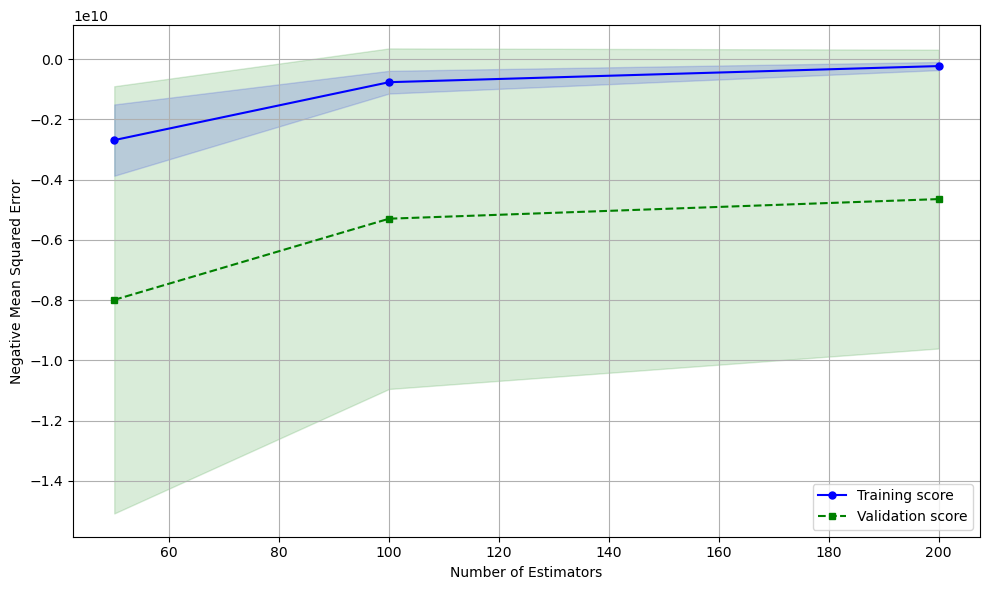

In [48]:
from sklearn.model_selection import validation_curve



best_params = grid_search_energy.best_params_

# Initialize the Gradient Boosting Regressor with best parameters from grid search
best_gb_energy = GradientBoostingRegressor(**best_params)

# Define the parameter range for 'n_estimators', ensuring it includes the best 'n_estimators' value
n_estimators_best = best_params['n_estimators']
param_range = [n_estimators_best // 2, n_estimators_best, n_estimators_best * 2]

# Use validation_curve to analyze 'n_estimators' effect
train_scores, test_scores = validation_curve(
    estimator=best_gb_energy,
    X=X_train_actual_energy,
    y=y_train_actual_energy,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative Mean Squared Error')
plt.tight_layout()
plt.show()


# Hyper Parameter Tunning on the Random Forest Model for Energy Consumption

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define the parameter grid for RandomForestRegressor
param_grid_energy_rf = {
     'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5]  
}

# Initialize RandomForestRegressor
rf_energy = RandomForestRegressor()

# Create the grid search object
grid_search_energy_rf = GridSearchCV(estimator=rf_energy, param_grid=param_grid_energy_rf, 
                                     scoring='neg_mean_squared_error', 
                                     cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the energy data
grid_search_energy_rf.fit(X_train_actual_energy, y_train_actual_energy)

# Print the best parameters and estimator
print("Best parameters found for energy data: ", grid_search_energy_rf.best_params_)
print("Best cross-validation score (RMSE) for energy data: ", np.sqrt(-grid_search_energy_rf.best_score_))

# Get the best estimator for energy data
best_rf_energy = grid_search_energy_rf.best_estimator_
best_rf_energy.fit(X_train_actual_energy, y_train_actual_energy)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
62 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ROBERTECH\anacond

Best parameters found for energy data:  {'bootstrap': False, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score (RMSE) for energy data:  70230.29842349708


RandomForestRegressor(bootstrap=False, max_depth=4, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=50)

In [59]:
best_rf_energy = best_rf_energy.fit(X_train_actual_energy, y_train_actual_energy)

C:\Users\ROBERTECH\AppData\Local\Temp\ipykernel_1828\1211802087.py:36: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(param_range, np.sqrt(-test_mean - test_std), np.sqrt(-test_mean + test_std), color="green", alpha=0.2)


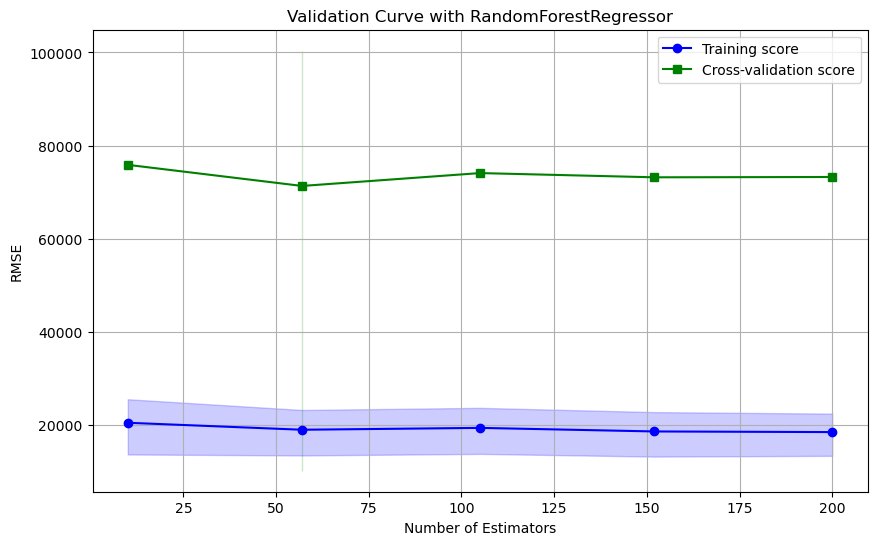

In [53]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the range of values for the 'n_estimators' parameter
param_range = np.linspace(10, 200, 5).astype(int)

# Compute the validation curve
train_scores, test_scores = validation_curve(
    RandomForestRegressor(max_depth=best_rf_energy.max_depth,
                          min_samples_split=best_rf_energy.min_samples_split,
                          min_samples_leaf=best_rf_energy.min_samples_leaf,
                          max_features=best_rf_energy.max_features,
                          bootstrap=best_rf_energy.bootstrap,
                          random_state=best_rf_energy.random_state), # Ensuring other parameters are consistent
    X_train_actual_energy, 
    y_train_actual_energy, 
    param_name="n_estimators", 
    param_range=param_range, 
    cv=3, 
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, np.sqrt(-train_mean), label="Training score", color="blue", marker='o')
plt.fill_between(param_range, np.sqrt(-train_mean - train_std), np.sqrt(-train_mean + train_std), color="blue", alpha=0.2)
plt.plot(param_range, np.sqrt(-test_mean), label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, np.sqrt(-test_mean - test_std), np.sqrt(-test_mean + test_std), color="green", alpha=0.2)

plt.title("Validation Curve with RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


## Hyper Parameter Tunning on the Gradient Boost Model for Treated Water

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Define the parameter grid for Gradient Boosting
param_grid_gb_treated = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5],  
    'subsample': [0.5, 0.75, 1.0]  
}

# Initialize Gradient Boosting Regressor
gb_treated = GradientBoostingRegressor()

# Create the grid search object
grid_search_gb_treated = GridSearchCV(estimator=gb_treated, param_grid=param_grid_gb_treated, 
                                      scoring='neg_mean_squared_error', 
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the data
grid_search_gb_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for Gradient Boosting: ", grid_search_gb_treated.best_params_)
print("Best cross-validation score (RMSE) for Gradient Boosting: ", np.sqrt(-grid_search_gb_treated.best_score_))

# Get the best estimator for Gradient Boosting
best_gb_treated = grid_search_gb_treated.best_estimator_
best_gb_treated.fit(X_train_actual, y_train_treated_actual)


Fitting 3 folds for each of 128 candidates, totalling 384 fits


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
192 fits failed out of a total of 384.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
97 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ROBERTECH\anacon

Best parameters found for Gradient Boosting:  {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.75}
Best cross-validation score (RMSE) for Gradient Boosting:  1.1310208092067688


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, max_features='sqrt',
                          min_samples_leaf=2, min_samples_split=5,
                          subsample=0.75)

In [60]:
best_gb_treated = best_gb_treated.fit(X_train_actual, y_train_treated_actual)

# Validation Curve for the best GB model on Treated Water

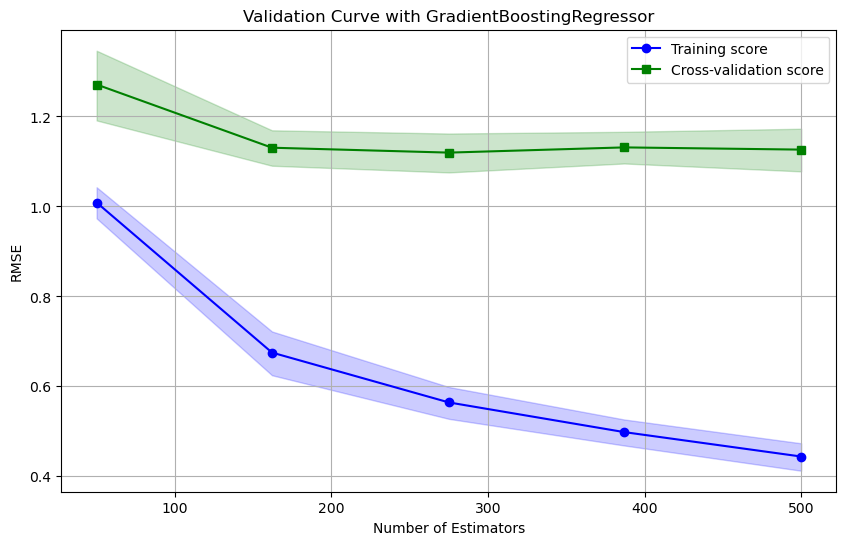

In [55]:
from sklearn.model_selection import validation_curve

# Define the range of values for 'n_estimators'
param_range = np.linspace(50, 500, 5).astype(int)

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=GradientBoostingRegressor(learning_rate=best_gb_treated.learning_rate,
                                         max_depth=best_gb_treated.max_depth,
                                         min_samples_split=best_gb_treated.min_samples_split,
                                         min_samples_leaf=best_gb_treated.min_samples_leaf,
                                         max_features=best_gb_treated.max_features,
                                         subsample=best_gb_treated.subsample,
                                         random_state=best_gb_treated.random_state),
    X=X_train_actual, 
    y=y_train_treated_actual, 
    param_name="n_estimators", 
    param_range=param_range, 
    cv=3, 
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, np.sqrt(-train_mean), label="Training score", color="blue", marker='o')
plt.fill_between(param_range, np.sqrt(-train_mean - train_std), np.sqrt(-train_mean + train_std), color="blue", alpha=0.2)
plt.plot(param_range, np.sqrt(-test_mean), label="Cross-validation score", color="green", marker='s')
plt.fill_between(param_range, np.sqrt(-test_mean - test_std), np.sqrt(-test_mean + test_std), color="green", alpha=0.2)

plt.title("Validation Curve with GradientBoostingRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# Hyper Parameter Tunning on the Random Model for Treated Water

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for Random Forest
param_grid_rf_treated = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', 0.3, 0.5]
}

# Initialize Random Forest Regressor
rf_treated = RandomForestRegressor()

# Create the grid search object
grid_search_rf_treated = GridSearchCV(estimator=rf_treated, param_grid=param_grid_rf_treated, 
                                      scoring='neg_mean_squared_error', 
                                      cv=3, n_jobs=-1, verbose=2)

# Fit the grid search object to the data
grid_search_rf_treated.fit(X_train_actual, y_train_treated_actual)

# Print the best parameters and estimator
print("Best parameters found for Random Forest: ", grid_search_rf_treated.best_params_)
print("Best cross-validation score (RMSE) for Random Forest: ", np.sqrt(-grid_search_rf_treated.best_score_))

# Get the best estimator for Random Forest
best_rf_treated = grid_search_rf_treated.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ROBERTECH\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ROBERTECH\anacon

Best parameters found for Random Forest:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score (RMSE) for Random Forest:  1.1111241534432121


In [61]:
best_rf_treated = best_rf_treated.fit(X_train_actual, y_train_treated_actual)

# Validation Curve for Best Random Forest Model on Treated Water

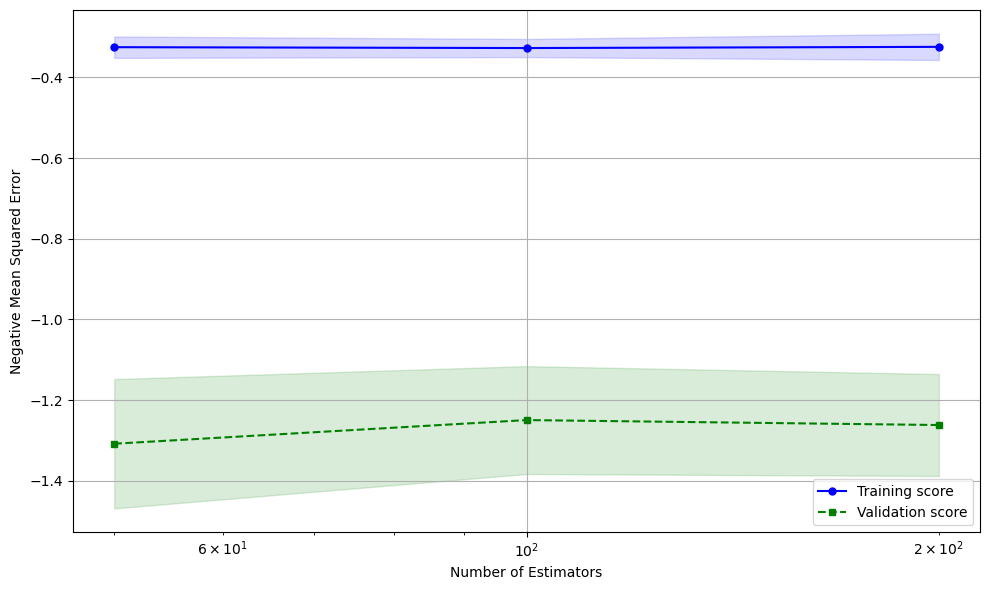

In [51]:
from sklearn.model_selection import validation_curve

best_rf_treated = grid_search_rf_treated.best_estimator_

# Define the parameter range for 'n_estimators'
param_range = [50, 100, 200]

# Use validation_curve with the RandomForestRegressor
train_scores, test_scores = validation_curve(
    estimator=best_rf_treated,
    X=X_train_actual,
    y=y_train_treated_actual,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Number of Estimators')
plt.ylabel('Negative Mean Squared Error')
plt.tight_layout()
plt.show()


# Hyper-Parameter Tunning on the SARIMA Model for Energy Consumption

In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

def evaluate_predictions(y_true, y_pred, model_name):
    """
    Evaluate and print RMSE, MAE, and Error Rate for a given model's predictions.
    """
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    err_rate = error(y_true, y_pred)
    
    print(f"=== {model_name} ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Error Rate: {err_rate:.4f}\n")
    return rmse, mae, err_rate

def main():
    # Evaluating Water Flow Predictions
    print("Evaluations for Water Flow:\n")
    evaluate_predictions(y_test_treated_actual, rf_pred_flow, "Random Forest")
    evaluate_predictions(y_test_treated_actual, gb_pred_flow, "Gradient Boosting")
   
    
    # Evaluating Energy Consumption Predictions
    print("Evaluations for Energy Consumption:\n")
    evaluate_predictions(y_test_actual_energy, rf_pred_energy, "Random Forest")
    evaluate_predictions(y_test_actual_energy, gb_pred_energy, "Gradient Boosting")
    evaluate_predictions(y_test_actual_energy, sarima_pred_energy, "SARIMA")
    evaluate_predictions(y_test_actual_energy, ensemble_pred_energy, "Ensemble")

# Run the evaluations
main()

Best SARIMA parameters for energy data:  (0, 1, 0) (2, 2, 2, 12)
Best AIC for energy data:  17145.303163080785


# Evaluation for Tuned GB Models on Treated Water

In [131]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_sarima_model_energy = SARIMAX(y_train_actual_energy, order=best_order).fit()

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Making predictions on the training set for Treated Water data
y_pred_train_treated = best_gb.predict(X_train_actual)

# Calculate RMSE, MAE, and Error Rate for the training set for Treated Water data
rmse_train_treated = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated))
mae_train_treated = mean_absolute_error(y_train_treated_actual, y_pred_train_treated)
error_train_treated = error(y_train_treated_actual, y_pred_train_treated)

# Making predictions on the test set for Treated Water data
y_pred_tuned_treated = best_gb.predict(X_test_actual)

# Calculate RMSE, MAE, and Error Rate for the test set for Treated Water data
rmse_test_treated = sqrt(mean_squared_error(y_test_treated_actual, y_pred_tuned_treated))
mae_test_treated = mean_absolute_error(y_test_treated_actual, y_pred_tuned_treated)
error_test_treated = error(y_test_treated_actual, y_pred_tuned_treated)

# Displaying the results
print("=== Hyperparameter-tuned Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated:.4f}")
print(f"MAE: {mae_train_treated:.4f}")
print(f"Error Rate: {error_train_treated:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated:.4f}")
print(f"MAE: {mae_test_treated:.4f}")
print(f"Error Rate: {error_test_treated:.4f}")

=== Hyperparameter-tuned Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.6793
MAE: 0.3319
Error Rate: 0.1829

--- Test Set ---
RMSE: 1.5998
MAE: 0.8681
Error Rate: 0.3965


# Evaluation of Tuned GB and RF  Model for Energy Consumption

In [63]:

# --- GB Model Predictions and Evaluations ---
y_pred_train_energy_gb = best_gb_energy.predict(X_train_actual_energy)
rmse_train_energy_gb = sqrt(mean_squared_error(y_train_actual_energy, y_pred_train_energy_gb))
mae_train_energy_gb = mean_absolute_error(y_train_actual_energy, y_pred_train_energy_gb)
error_train_energy_gb = error(y_train_actual_energy, y_pred_train_energy_gb)

y_pred_test_energy_gb = best_gb_energy.predict(X_test_actual_energy)
rmse_test_energy_gb = sqrt(mean_squared_error(y_test_actual_energy, y_pred_test_energy_gb))
mae_test_energy_gb = mean_absolute_error(y_test_actual_energy, y_pred_test_energy_gb)
error_test_energy_gb = error(y_test_actual_energy, y_pred_test_energy_gb)

print("=== GB Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_gb:.4f}")
print(f"MAE: {mae_train_energy_gb:.4f}")
print(f"Error Rate: {error_train_energy_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_gb:.4f}")
print(f"MAE: {mae_test_energy_gb:.4f}")
print(f"Error Rate: {error_test_energy_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_energy_rf = best_rf_energy.predict(X_train_actual_energy)
rmse_train_energy_rf = sqrt(mean_squared_error(y_train_actual_energy, y_pred_train_energy_rf))
mae_train_energy_rf = mean_absolute_error(y_train_actual_energy, y_pred_train_energy_rf)
error_train_energy_rf = error(y_train_actual_energy, y_pred_train_energy_rf)

y_pred_test_energy_rf = best_rf_energy.predict(X_test_actual_energy)
rmse_test_energy_rf = sqrt(mean_squared_error(y_test_actual_energy, y_pred_test_energy_rf))
mae_test_energy_rf = mean_absolute_error(y_test_actual_energy, y_pred_test_energy_rf)
error_test_energy_rf = error(y_test_actual_energy, y_pred_test_energy_rf)

print("=== RF Model Evaluation for Energy Consumption ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_energy_rf:.4f}")
print(f"MAE: {mae_train_energy_rf:.4f}")
print(f"Error Rate: {error_train_energy_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_energy_rf:.4f}")
print(f"MAE: {mae_test_energy_rf:.4f}")
print(f"Error Rate: {error_test_energy_rf:.4f}\n")




=== GB Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 30645.7392
MAE: 19421.6895
Error Rate: 0.9987

--- Test Set ---
RMSE: 78909.3426
MAE: 44171.9260
Error Rate: 1.0000

=== RF Model Evaluation for Energy Consumption ===

--- Training Set ---
RMSE: 24867.2446
MAE: 16752.4602
Error Rate: 1.0000

--- Test Set ---
RMSE: 77444.2725
MAE: 44745.7911
Error Rate: 1.0000



# Evaluation of Tuned GB and RF Model for Treated Water

In [67]:
# --- GB Model Predictions and Evaluations ---
y_pred_train_treated_gb = best_gb_treated.predict(X_train_actual)
rmse_train_treated_gb = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_gb))
mae_train_treated_gb = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_gb)
error_train_treated_gb = error(y_train_treated_actual, y_pred_train_treated_gb)

y_pred_test_treated_gb = best_gb_treated.predict(X_test_actual)
rmse_test_treated_gb = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_gb))
mae_test_treated_gb = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_gb)
error_test_treated_gb = error(y_test_treated_actual, y_pred_test_treated_gb)

print("=== GB Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_gb:.4f}")
print(f"MAE: {mae_train_treated_gb:.4f}")
print(f"Error Rate: {error_train_treated_gb:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_gb:.4f}")
print(f"MAE: {mae_test_treated_gb:.4f}")
print(f"Error Rate: {error_test_treated_gb:.4f}\n")


# --- RF Model Predictions and Evaluations ---
y_pred_train_treated_rf = best_rf_treated.predict(X_train_actual)
rmse_train_treated_rf = sqrt(mean_squared_error(y_train_treated_actual, y_pred_train_treated_rf))
mae_train_treated_rf = mean_absolute_error(y_train_treated_actual, y_pred_train_treated_rf)
error_train_treated_rf = error(y_train_treated_actual, y_pred_train_treated_rf)

y_pred_test_treated_rf = best_rf_treated.predict(X_test_actual)
rmse_test_treated_rf = sqrt(mean_squared_error(y_test_treated_actual, y_pred_test_treated_rf))
mae_test_treated_rf = mean_absolute_error(y_test_treated_actual, y_pred_test_treated_rf)
error_test_treated_rf = error(y_test_treated_actual, y_pred_test_treated_rf)

print("=== RF Model Evaluation for Treated Water ===")
print("\n--- Training Set ---")
print(f"RMSE: {rmse_train_treated_rf:.4f}")
print(f"MAE: {mae_train_treated_rf:.4f}")
print(f"Error Rate: {error_train_treated_rf:.4f}")

print("\n--- Test Set ---")
print(f"RMSE: {rmse_test_treated_rf:.4f}")
print(f"MAE: {mae_test_treated_rf:.4f}")
print(f"Error Rate: {error_test_treated_rf:.4f}\n")




=== GB Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.8404
MAE: 0.4200
Error Rate: 0.2119

--- Test Set ---
RMSE: 1.5779
MAE: 0.8587
Error Rate: 0.3692

=== RF Model Evaluation for Treated Water ===

--- Training Set ---
RMSE: 0.5935
MAE: 0.2773
Error Rate: 0.1363

--- Test Set ---
RMSE: 1.5085
MAE: 0.7892
Error Rate: 0.3547



# Prediction for Treated Water from best Model

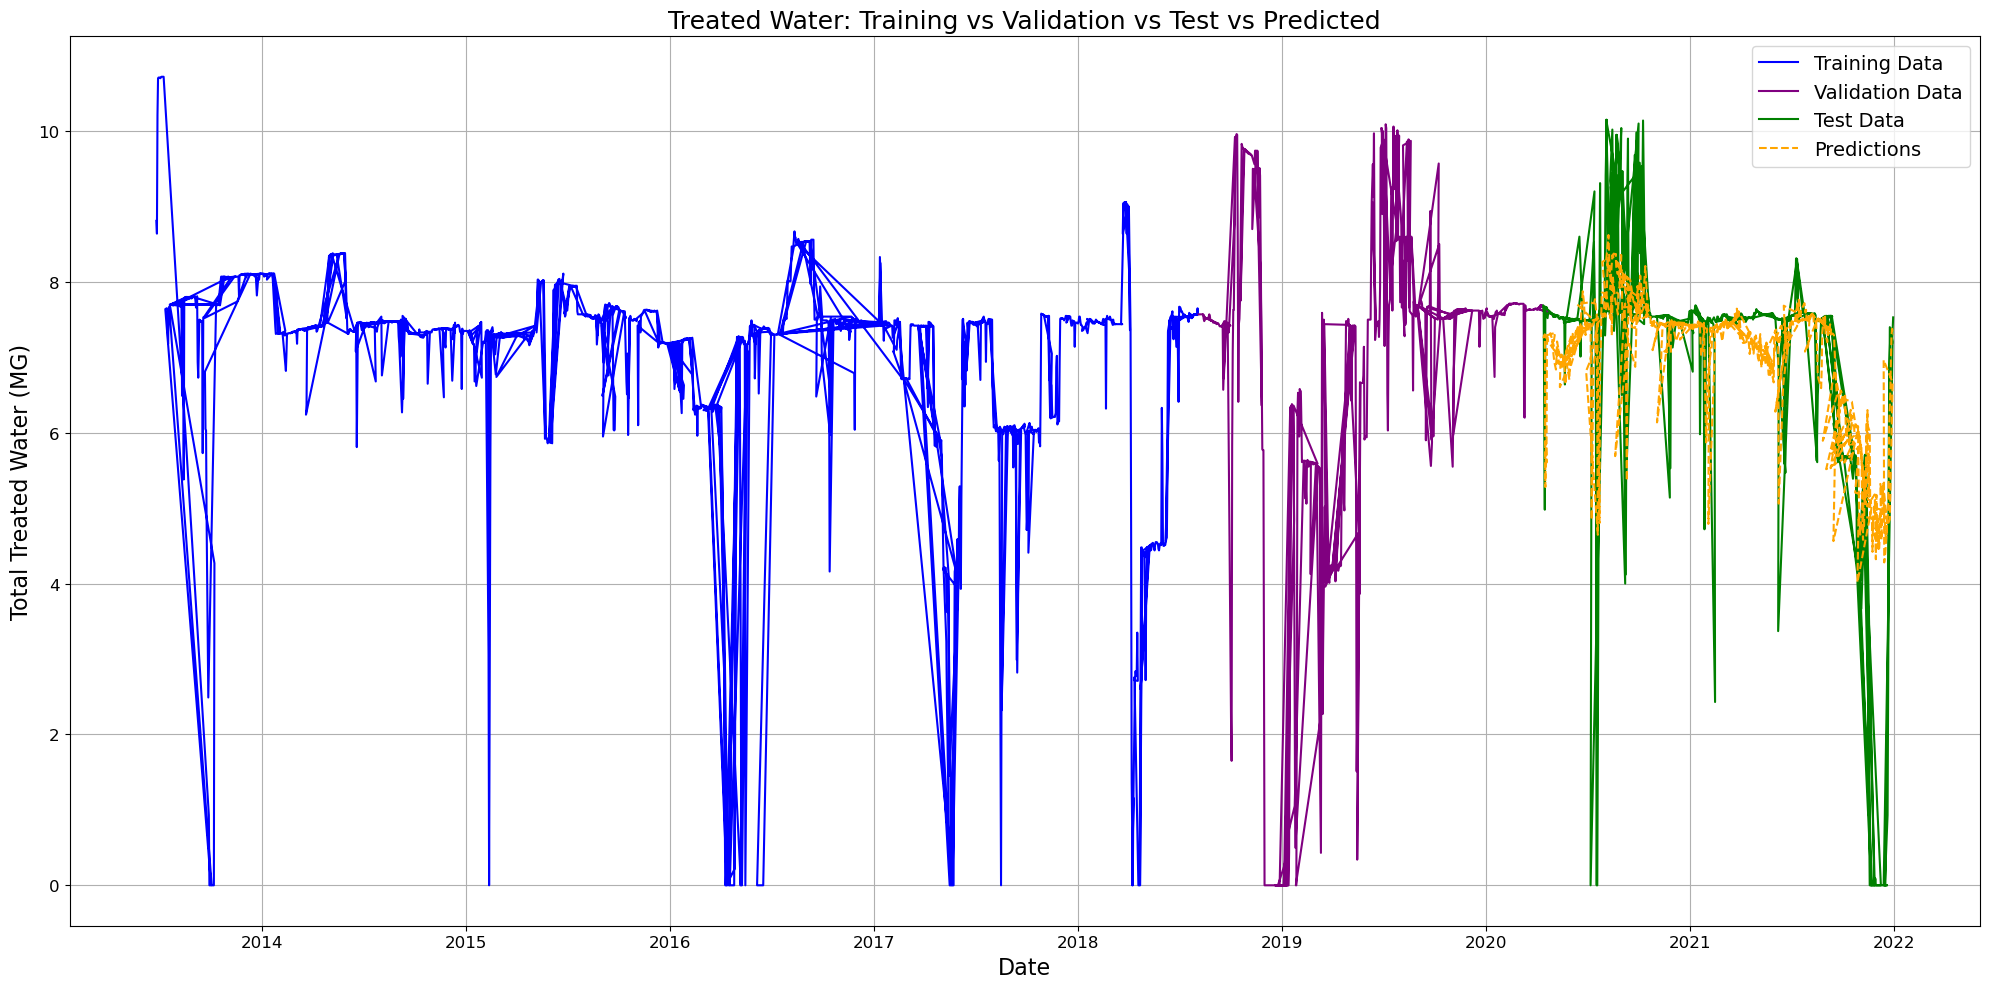

In [70]:
# Import necessary library
import matplotlib.pyplot as plt

# Plotting function for Treated Water data
def plot_treated_water_predictions(data, y_train, y_validation, y_test, y_pred):
    plt.figure(figsize=(20, 10))
    
    # Calculate indices for train, validation, and test data for correct plotting
    train_indices = data['Date'][:len(y_train)]
    validation_indices = data['Date'][len(y_train):len(y_train) + len(y_validation)]
    test_indices = data['Date'][len(y_train) + len(y_validation):]
    
    # Plot Training Data
    plt.plot(train_indices, y_train, label='Training Data', color='blue')
    
    # Plot Validation Data
    plt.plot(validation_indices, y_validation, label='Validation Data', color='purple')
    
    # Plot Test Data
    plt.plot(test_indices, y_test, label='Test Data', color='green')
    
    # Overlay Predicted Data (assuming the predictions are for test data)
    plt.plot(test_indices, y_pred, label='Predictions', color='orange', linestyle='--')
    
    # Add titles, labels, and legend with increased font sizes
    plt.title('Treated Water: Training vs Validation vs Test vs Predicted', fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Total Treated Water (MG)', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase the size of tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with appropriate arguments
plot_treated_water_predictions(flow_data, 
                               y_train_treated_actual, 
                               y_validation_treated_actual, 
                               y_test_treated_actual, 
                               y_pred_test_treated_rf)


# Prediction for Energy Consumption from GB Model

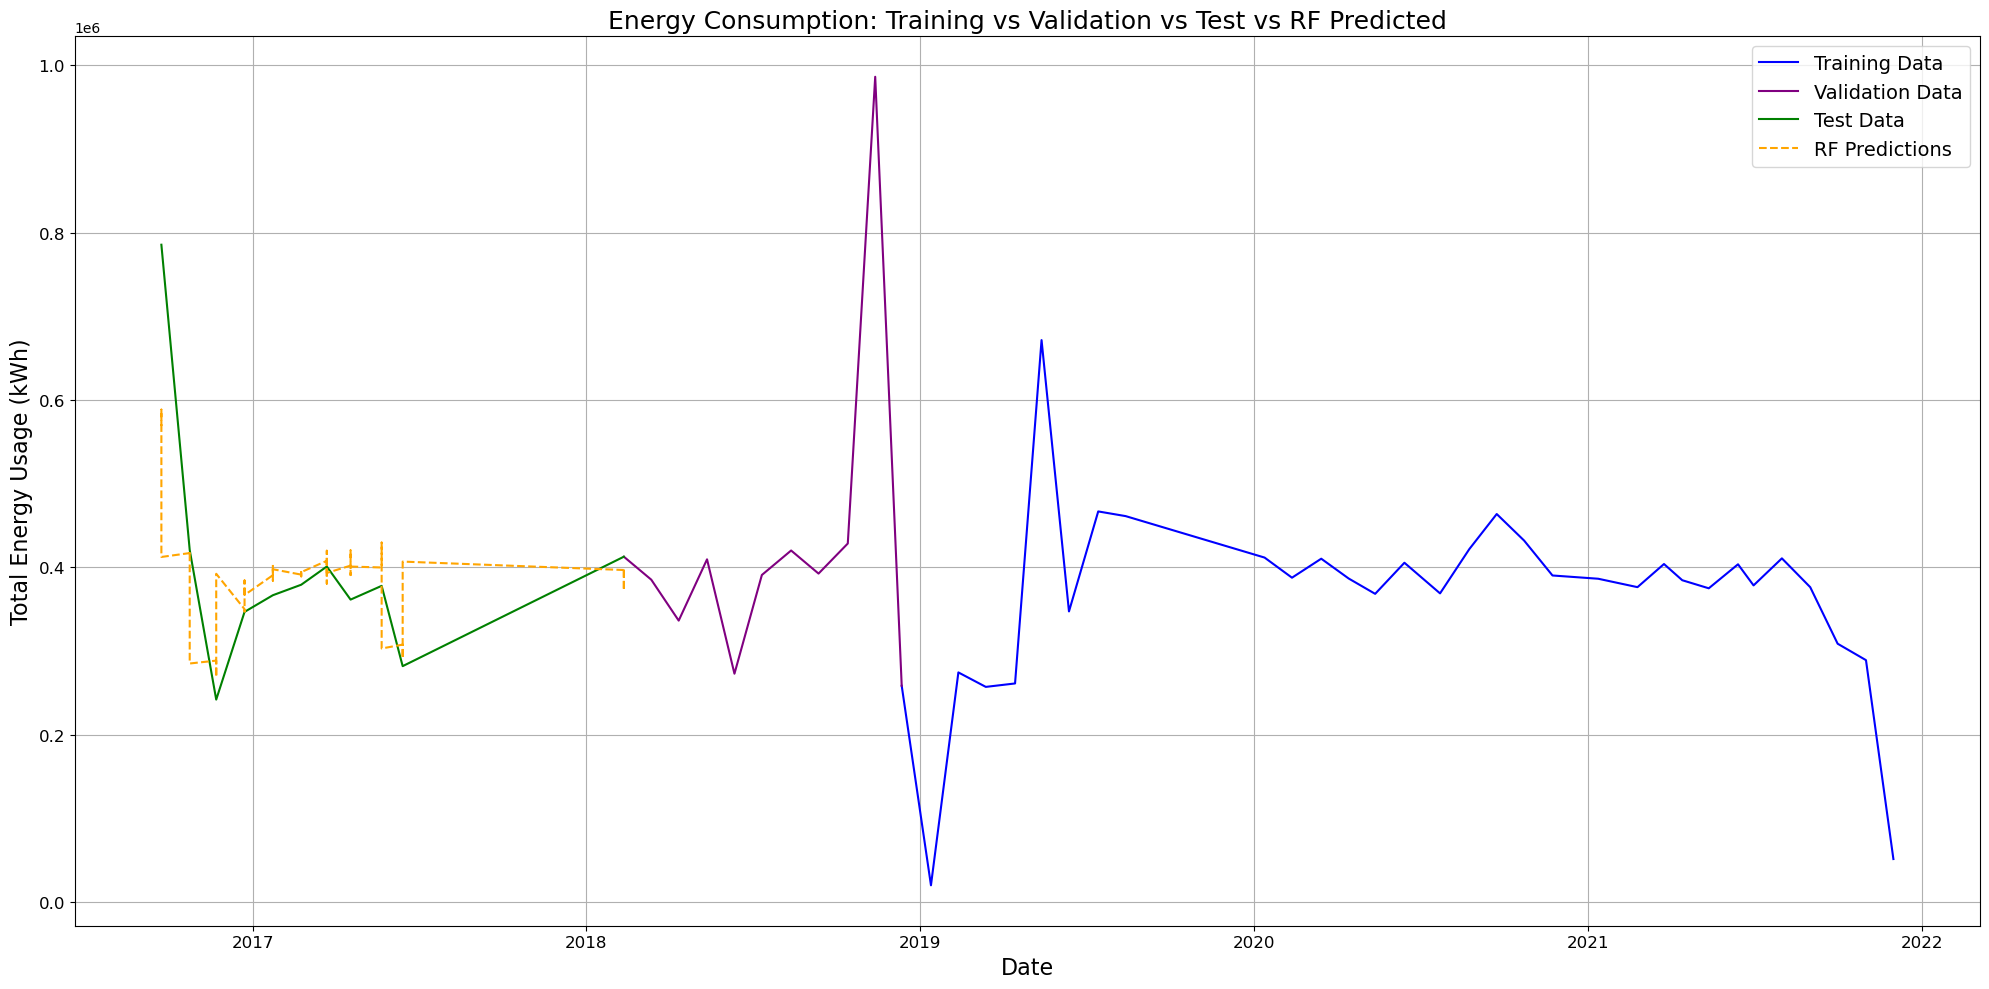

In [71]:
import matplotlib.pyplot as plt

# Plotting function for Energy Consumption data using RF predictions
def plot_energy_rf_predictions(data, y_train, y_validation, y_test, y_pred_rf):
    plt.figure(figsize=(20, 10))
    
    # Calculate indices for train, validation, and test data for correct plotting
    train_indices = data['Date'][:len(y_train)]
    validation_indices = data['Date'][len(y_train):len(y_train) + len(y_validation)]
    test_indices = data['Date'][len(y_train) + len(y_validation):len(y_train) + len(y_validation) + len(y_test)]
    
    # Plot Training Data
    plt.plot(train_indices, y_train, label='Training Data', color='blue')
    
    # Plot Validation Data
    plt.plot(validation_indices, y_validation, label='Validation Data', color='purple')
    
    # Plot Test Data
    plt.plot(test_indices, y_test, label='Test Data', color='green')
    
    # Overlay Predicted Data (RF predictions for test data)
    plt.plot(test_indices, y_pred_rf, label='RF Predictions', color='orange', linestyle='--')
    
    # Add titles, labels, and legend with increased font sizes
    plt.title('Energy Consumption: Training vs Validation vs Test vs RF Predicted', fontsize=18)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Total Energy Usage (kWh)', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase the size of tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming y_pred_rf_energy contains the RF predictions for the test set, call the function:
y_pred_rf_energy = best_rf_energy.predict(X_test_actual_energy)  # Ensure you've run your RF prediction first
plot_energy_rf_predictions(energy_data, y_train_actual_energy, y_validation_actual_energy, y_test_actual_energy, y_pred_rf_energy)


# 5 Years Prediction From the Best Models for Treated Water and Energy Consumption

In [73]:
import random

# Initialize lists to store predictions
treated_predictions = []
energy_predictions = []

In [74]:
# Number of loops needed to reach 1825 predictions
n_loops = 1825 // len(X_train_actual)  # Integer division to get full loops
remaining_rows = 1825 % len(X_train_actual)  # Remaining rows after full loops

In [75]:
# Number of loops needed to reach 1825 predictions
n_loops = 1825 // len(X_train_actual_energy)  # Integer division to get full loops
remaining_rows = 1825 % len(X_train_actual_energy)  # Remaining rows after full loops

In [76]:
X_future_flow = X_train_actual.iloc[:1825].reset_index(drop=True)

X_future_energy = X_train_actual_energy.iloc[:1825].reset_index(drop=True)


In [77]:
# Add the remaining rows
if remaining_rows > 0:
    X_future_energy = pd.concat([X_future_energy, X_train_actual_energy.iloc[:remaining_rows]], ignore_index=True)

In [78]:
# Make the predictions using the Best GB models for treated waters
pred_flow = best_rf_treated.predict(X_future_flow)


# Append the predictions to the lists
treated_predictions.extend(pred_flow)



In [79]:
# Make the predictions using the RF models for Energy Consumption
energy_predictions = best_rf_energy.predict(X_future_energy)

In [80]:
# Convert predictions to DataFrame
pred_flow = pd.DataFrame({
    'Treated_Water_Predictions': treated_predictions
})

In [81]:
# Convert predictions to DataFrame
pred_energy = pd.DataFrame({
    'Energy_Consumption_Predictions': energy_predictions
})

In [82]:
# Generate a date column for Flow prediction
last_date = pd.to_datetime(flow_data['Date'].iloc[-1])
future_dates_flow = pd.date_range(start=last_date, periods=len(treated_predictions) + 1, freq='D')[1:]

In [83]:
# Generate a date column for Energy prediction
last_date = pd.to_datetime(energy_data['Date'].iloc[-1])
future_dates_energy = pd.date_range(start=last_date, periods=len(energy_predictions), freq='D')

In [84]:
# Add the 'Date' column and rearrange it to be the first column for Flow Prediction
pred_flow['Date'] = future_dates_flow
pred_flow = pred_flow[['Date', 'Treated_Water_Predictions']]

In [85]:
# Ensure both have the same length before the assignment
assert len(pred_energy) == len(future_dates_energy), "Mismatch in lengths"

# Assign the date values
pred_energy['Date'] = future_dates_energy

# Rearrange columns
pred_energy = pred_energy[['Date', 'Energy_Consumption_Predictions']]


In [86]:
# Export to CSV
pred_flow.to_csv('Treated_Water_Predictions.csv', index=False)

In [87]:
# Export to CSV
pred_energy.to_csv('Energy_Consumption_Predictions.csv', index=False)

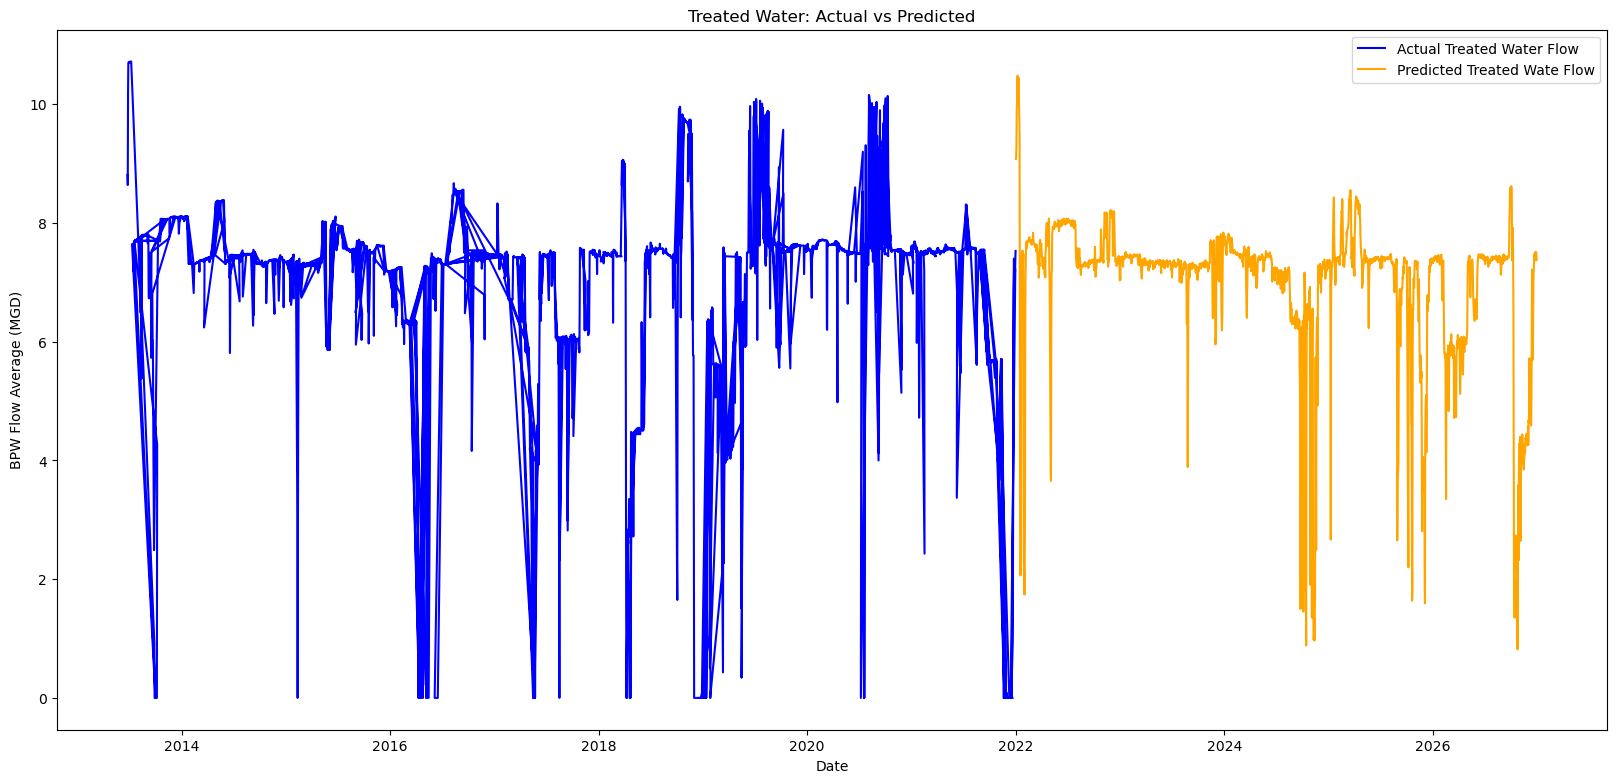

In [88]:
# Set the figure size
plt.figure(figsize=(20, 20))



# Plot  Treated Water Flow
plt.subplot(2, 1, 1)
plt.plot(flow_data['Date'], flow_data['BPW Flow Average (MGD)'], label='Actual Treated Water Flow', color='blue')
plt.plot(pred_flow['Date'], pred_flow['Treated_Water_Predictions'], label='Predicted Treated Wate Flow', color='orange')
plt.title('Treated Water: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('BPW Flow Average (MGD)')
plt.legend()

plt.savefig("Predicted Treated water for Alameda Site.png", dpi=300, bbox_inches='tight')

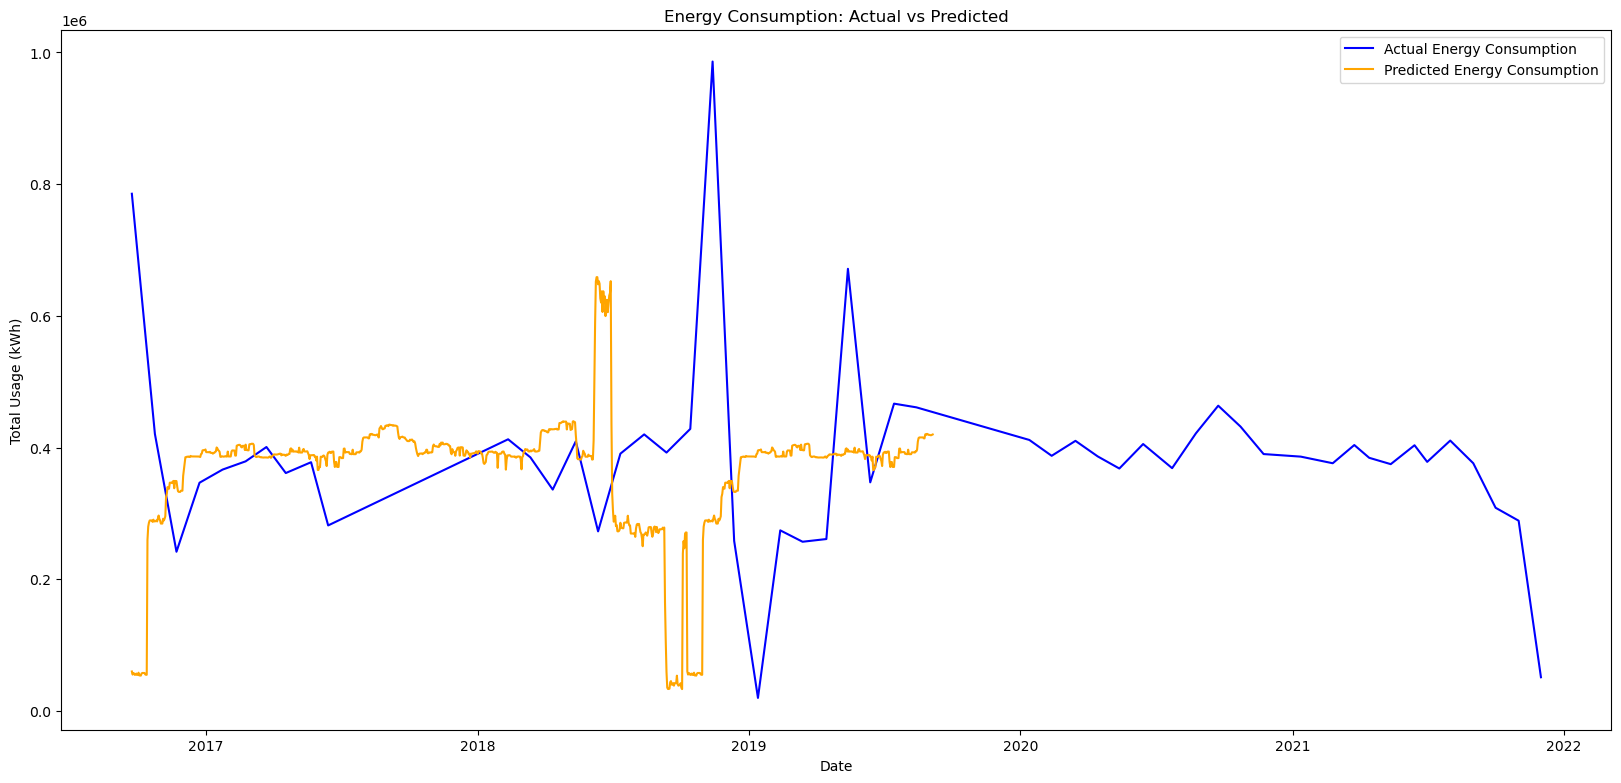

In [89]:
# Set the figure size
plt.figure(figsize=(20, 20))



# Plot  Energy Consumption
plt.subplot(2, 1, 1)
plt.plot(energy_data['Date'], energy_data['Total Usage (kWh)'], label='Actual Energy Consumption', color='blue')
plt.plot(pred_energy['Date'], pred_energy['Energy_Consumption_Predictions'], label='Predicted Energy Consumption', color='orange')
plt.title('Energy Consumption: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Total Usage (kWh)')
plt.legend()



plt.savefig("Predicted Treated water for Alameda Site.png", dpi=300, bbox_inches='tight')

# Saving the Best Model for both Treated Water and Energy Consumption

In [90]:
import pickle

# Saving the best Gradient Boosting model for treated water in Almeda
with open('best_rf_model_treated_almeda.pkl', 'wb') as f:
    pickle.dump(best_rf_treated, f)

# Saving the best Random Forest model for energy consumption in Almeda
with open('best_rf_model_energy_almeda.pkl', 'wb') as f:
    pickle.dump(best_rf_energy, f)
